In [ ]:
!pip install hdbscan
!pip install umap

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

In [ ]:
training_data = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
testing_data = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')

final_combined_data = pd.read_csv('/kaggle/input/final-combined/final_combined_data.csv')

In [3]:
import pickle

with open('/kaggle/input/slide-features55/512px_resnet50_55_slide_features.pkl', 'rb') as f:
    slide_features = pickle.load(f)

In [4]:
from sklearn.model_selection import train_test_split

# Convert slide_features to a list of tuples (features, label)
data = [(features['features'], features['label']) for path, features in slide_features.items()]

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
print(len(train_data), len(test_data))

44 11


In [8]:
import umap.umap_ as umap
import hdbscan

# Flatten the feature vectors and labels from the training data
train_features_flat = []
train_labels_flat = []
for bag, label in train_data:
    train_features_flat.extend(bag)
    train_labels_flat.extend([label] * len(bag))

# Convert to NumPy arrays
train_features_flat = np.array(train_features_flat)
train_labels_flat = np.array(train_labels_flat)

# UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
umap_embedding_train = umap_reducer.fit_transform(train_features_flat)

In [9]:
# HDBSCAN for clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=50, cluster_selection_epsilon=0.25)
cluster_labels_train = clusterer.fit_predict(umap_embedding_train)

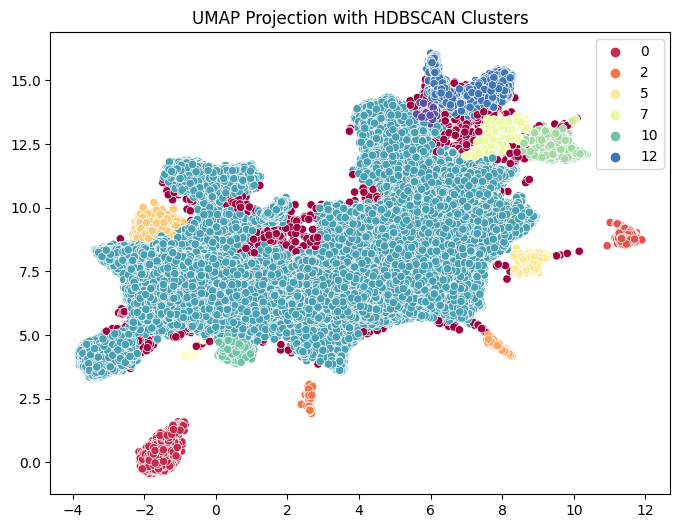

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embedding_train[:, 0], y=umap_embedding_train[:, 1], hue=cluster_labels_train, palette='Spectral')
plt.title('UMAP Projection with HDBSCAN Clusters')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Overall silhouette score
overall_silhouette_score = silhouette_score(umap_embedding_train, cluster_labels_train)
print("Overall Silhouette Score: ", overall_silhouette_score)

# Silhouette scores for each cluster
silhouette_vals = silhouette_samples(umap_embedding_train, cluster_labels_train)
cluster_avg_silhouette = pd.DataFrame({'Silhouette': silhouette_vals, 'Cluster': cluster_labels_train}).groupby('Cluster')['Silhouette'].mean()
for cluster, score in cluster_avg_silhouette.items():
    print(f"Cluster {cluster} average silhouette score: {score:.4f}")

Overall Silhouette Score:  -0.28613076
Cluster -1 average silhouette score: -0.5747
Cluster 0 average silhouette score: 0.8519
Cluster 1 average silhouette score: 0.9157
Cluster 2 average silhouette score: 0.9136
Cluster 3 average silhouette score: 0.9457
Cluster 4 average silhouette score: 0.9163
Cluster 5 average silhouette score: 0.8885
Cluster 6 average silhouette score: 0.8724
Cluster 7 average silhouette score: 0.5830
Cluster 8 average silhouette score: 0.9495
Cluster 9 average silhouette score: 0.4161
Cluster 10 average silhouette score: 0.6716
Cluster 11 average silhouette score: -0.4690
Cluster 12 average silhouette score: 0.2487
Cluster 13 average silhouette score: 0.8683


In [12]:
columns = [f'UMAP_{i+1}' for i in range(umap_embedding_train.shape[1])]
embedding_df_train = pd.DataFrame(umap_embedding_train, columns=columns)
embedding_df_train['Cluster'] = cluster_labels_train

# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df_train['Label'] = train_labels_flat

# Analyze the labels for each cluster
for cluster in range(-1, 17):  # Assuming clusters are numbered 0 to 4
    cluster_data_train = embedding_df_train[embedding_df_train['Cluster'] == cluster]
    label_counts = cluster_data_train['Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    '''
    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()
    '''

Cluster -1 label distribution:
Label
EC      193
MC      148
LGSC    145
CC      119
HGSC    107
Name: count, dtype: int64

Cluster 0 label distribution:
Label
CC      3419
MC        15
HGSC      11
EC         1
Name: count, dtype: int64

Cluster 1 label distribution:
Label
LGSC    849
EC        1
Name: count, dtype: int64

Cluster 2 label distribution:
Label
MC      391
HGSC      2
Name: count, dtype: int64

Cluster 3 label distribution:
Label
HGSC    432
MC        9
LGSC      2
Name: count, dtype: int64

Cluster 4 label distribution:
Label
MC      2067
EC        31
HGSC      20
LGSC      12
CC         7
Name: count, dtype: int64

Cluster 5 label distribution:
Label
LGSC    597
MC        5
CC        2
EC        1
Name: count, dtype: int64

Cluster 6 label distribution:
Label
HGSC    50
MC       3
CC       1
Name: count, dtype: int64

Cluster 7 label distribution:
Label
EC      1182
MC       240
CC       207
LGSC      43
HGSC      28
Name: count, dtype: int64

Cluster 8 label distribut

In [13]:
from collections import Counter

# Set a minimum threshold for homogeneity
homogeneity_min = 0.8

# Dictionary to hold the dominant label for each cluster
dominant_labels = {}

# Analyze each cluster
for cluster in np.unique(cluster_labels_train):
    if cluster == -1:  # Exclude noise
        continue

    # Get indices of feature vectors in the current cluster
    indices = np.where(cluster_labels_train == cluster)[0]
    
    # Count the labels in this cluster
    label_counts = Counter(train_labels_flat[indices])
    
    # Calculate homogeneity and determine the dominant label
    total = sum(label_counts.values())
    most_common_label, count = label_counts.most_common(1)[0]
    homogeneity = count / total

    # Check if the cluster meets the homogeneity threshold
    if homogeneity >= homogeneity_min:
        dominant_labels[cluster] = most_common_label
        print(f"Cluster {cluster}, Dominant Label: {most_common_label}, Homogeneity: {homogeneity:.2f}")

# dominant_labels now contains the dominant label for each sufficiently homogeneous cluster

Cluster 0, Dominant Label: CC, Homogeneity: 0.99
Cluster 1, Dominant Label: LGSC, Homogeneity: 1.00
Cluster 2, Dominant Label: MC, Homogeneity: 0.99
Cluster 3, Dominant Label: HGSC, Homogeneity: 0.98
Cluster 4, Dominant Label: MC, Homogeneity: 0.97
Cluster 5, Dominant Label: LGSC, Homogeneity: 0.99
Cluster 6, Dominant Label: HGSC, Homogeneity: 0.93
Cluster 8, Dominant Label: EC, Homogeneity: 0.96
Cluster 9, Dominant Label: HGSC, Homogeneity: 0.87
Cluster 10, Dominant Label: CC, Homogeneity: 0.97
Cluster 12, Dominant Label: EC, Homogeneity: 0.97
Cluster 13, Dominant Label: HGSC, Homogeneity: 0.92


In [14]:
from collections import defaultdict

# Dictionary to hold aggregated feature vectors for each dominant label
aggregated_features = defaultdict(list)

# Aggregate feature vectors for each dominant label
for cluster, dominant_label in dominant_labels.items():
    # Get indices of feature vectors in the current cluster belonging to the dominant label
    indices = [i for i, label in enumerate(train_labels_flat) if label == dominant_label and cluster_labels_train[i] == cluster]

    # Aggregate feature vectors (mean)
    if indices:
        aggregated_vector = np.mean(train_features_flat[indices], axis=0)
        aggregated_features[dominant_label].append(aggregated_vector)

# Convert aggregated features to a suitable format for training the classifier
classifier_train_data = []
for label, features_list in aggregated_features.items():
    for features in features_list:
        classifier_train_data.append((features, label))

# Shuffle the data
np.random.shuffle(classifier_train_data)

# Separate features and labels
X_train = [features for features, _ in classifier_train_data]
y_train = [label for _, label in classifier_train_data]

# Convert to NumPy arrays for classifier training
X_train = np.array(X_train)
y_train = np.array(y_train)

In [15]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_classifier = SVC()

# Train the classifier
svm_classifier.fit(X_train, y_train)

print("SVM classifier training complete.")

SVM classifier training complete.


In [16]:
# Flatten the feature vectors from the test data
test_features_flat = [feature for bag, _ in test_data for feature in bag]

# Convert to NumPy array
test_features_flat = np.array(test_features_flat)

# Apply UMAP reduction to test data
umap_embedding_test = umap_reducer.transform(test_features_flat)

# Apply HDBSCAN clustering to the UMAP reduced test data
cluster_labels_test = clusterer.fit_predict(umap_embedding_test)

In [17]:
# Find the largest cluster
largest_cluster = np.argmax(np.bincount(cluster_labels_test[cluster_labels_test >= 0]))

# Exclude the largest cluster from the aggregation process
aggregated_test_features = []
for cluster in np.unique(cluster_labels_test):
    if cluster != largest_cluster and cluster != -1:
        cluster_feature_indices = np.where(cluster_labels_test == cluster)[0]
        if len(cluster_feature_indices) > 0:
            aggregated_cluster_features = np.mean(test_features_flat[cluster_feature_indices], axis=0)
            aggregated_test_features.append(aggregated_cluster_features)

aggregated_test_features = np.array(aggregated_test_features)

print("Excluded largest cluster and completed test data clustering and aggregation.")

Excluded largest cluster and completed test data clustering and aggregation.


In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Feature scaling and SVM classifier pipeline
svm_pipeline = make_pipeline(StandardScaler(), SVC())

# Define a grid of parameters to search
param_grid = {
    'svc__C': [1, 5, 10],
    'svc__gamma': [0.5, 0.1, 10],
    'svc__kernel': ['sigmoid']
}

# Grid search with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=4, scoring='accuracy', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best estimator for predictions
svm_classifier = grid_search.best_estimator_

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END ......svc__C=1, svc__gamma=0.5, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=1, svc__gamma=0.5, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=1, svc__gamma=0.5, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=1, svc__gamma=0.5, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END ......svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; total time=   0.0s
[CV] END .......svc__C=1, svc__gamma=10, svc__kernel=sigmoid; total time=   0.0s
[CV] END .......svc__C=1, svc__gamma=10, svc__kernel=sigmoid; total time=   0.0s
[CV] END .......svc__C=1, svc__gamma=10, svc__kernel=sigmoid; total time=   0.0s
[CV] END .......svc__C=1, svc__gamma=10, svc__ker

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


In [19]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Create a pipeline with scaling and SVM using 'poly' kernel
svm_poly_pipeline = make_pipeline(StandardScaler(), SVC(kernel='poly'))

# Set up the grid search parameters
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.01]
}

# Create and conduct the grid search
grid_search_poly = GridSearchCV(svm_poly_pipeline, param_grid, cv=4, scoring='accuracy')
grid_search_poly.fit(X_train, y_train)

# Display best parameters
print("Best parameters for poly SVM:", grid_search_poly.best_params_)

# Use the best estimator to make predictions on the test set
best_poly_svm = grid_search_poly.best_estimator_

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(


Best parameters for poly SVM: {'svc__C': 0.1, 'svc__gamma': 0.01}


In [20]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create two SVM pipelines
svm_poly = make_pipeline(StandardScaler(), SVC(kernel='poly', C=1, gamma=0.001, class_weight='balanced'))
svm_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=0.06, gamma=0.001, class_weight='balanced'))
svm_sigmoid = make_pipeline(StandardScaler(), SVC(kernel='sigmoid', C=6, gamma=0.000, class_weight='balanced'))

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[('svm_poly', svm_poly), ('svm_sigmoid', svm_sigmoid), ('svm_rbf', svm_rbf)], voting='hard')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Use voting_clf to make predictions

VotingClassifier(estimators=[('svm_poly',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=1, class_weight='balanced',
                                                   gamma=0.001,
                                                   kernel='poly'))])),
                             ('svm_sigmoid',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=6, class_weight='balanced',
                                                   gamma=0.0,
                                                   kernel='sigmoid'))])),
                             ('svm_rbf',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=0.06,
                                                   class_weight='balanced',
                                                   gamma=0.001))]))])

In [21]:
# Assuming svm_classifier is your trained SVM classifier
predicted_labels_for_clusters = svm_classifier.predict(aggregated_test_features)
predicted_labels_for_clusters

array(['MC', 'HGSC'], dtype='<U4')

In [22]:
# Assign Labels to Test Bags
bag_predictions = []

for bag_features, _ in test_data:  # Assuming test_data is a list of (bag, label) tuples
    cluster_labels_for_bag = []
    
    # Iterate over each feature vector in the bag
    for feature in bag_features:
        # Find the index of the feature vector in the test_features_flat
        feature_index = np.where(np.all(test_features_flat == np.array(feature), axis=1))[0]
        
        if feature_index.size > 0:
            # Get the cluster label for this feature vector
            cluster_label = cluster_labels_test[feature_index[0]]
            cluster_labels_for_bag.append(cluster_label)
    
    # If bag's features don't belong to any cluster or belong only to excluded clusters, assign 'Other'
    if not cluster_labels_for_bag or all(label in [largest_cluster, -1] for label in cluster_labels_for_bag):
        bag_predictions.append('Other')
        continue
    
    # Filter out the clusters that are excluded
    relevant_cluster_labels = [label for label in cluster_labels_for_bag if label not in [largest_cluster, -1]]
    
    # Get the predicted labels for the relevant clusters
    predicted_labels_for_bag = predicted_labels_for_clusters[relevant_cluster_labels]
    
    # Convert string labels to integer indices
    label_indices = [np.where(svm_classifier.classes_ == label)[0][0] for label in predicted_labels_for_bag]
    
    # Count the frequency of each label using the classifier's classes
    num_unique_labels = len(svm_classifier.classes_)
    label_counts = np.bincount(label_indices, minlength=num_unique_labels)
    dominant_label_index = np.argmax(label_counts)

    # Assign label based on the dominant label index
    assigned_label = svm_classifier.classes_[dominant_label_index]
    bag_predictions.append(assigned_label)

# bag_predictions now contains the predicted label for each test bag

In [23]:
# aggregating cluster feature vectors
# Process and classify each test bag
bag_predictions = []

for bag_features, _ in test_data:  # Assuming test_data is a list of (bag, label) tuples
    # Apply UMAP reduction to the bag's features
    umap_embedding_bag = umap_reducer.transform(np.array(bag_features))
    
    # Apply HDBSCAN clustering to the UMAP reduced bag features
    cluster_labels_bag = clusterer.fit_predict(umap_embedding_bag)
    
    # Exclude features from the largest and noise clusters
    relevant_features = [bag_features[i] for i, label in enumerate(cluster_labels_bag) if label not in [largest_cluster, -1]]

    # Aggregate the relevant features
    if relevant_features:
        aggregated_features = np.mean(np.array(relevant_features), axis=0)
    else:
        # If all features are excluded, assign 'Other'
        bag_predictions.append('Other')
        continue
    
    # Predict the label for the aggregated features
    predicted_label = svm_classifier.predict(aggregated_features.reshape(1, -1))[0]
    bag_predictions.append(predicted_label)

# bag_predictions now contains the predicted label for each test bag

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract actual labels from the test data
actual_labels = [label for _, label in test_data]

# Convert predictions and actual labels to NumPy arrays for easier handling
predicted_labels = np.array(bag_predictions)
actual_labels = np.array(actual_labels)

# Calculate metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=1)
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.0909
Precision: 0.1169
Recall: 0.0909
F1 Score: 0.0404


In [25]:
print(bag_predictions)
print(actual_labels)

['EC', 'HGSC', 'MC', 'MC', 'MC', 'MC', 'MC', 'LGSC', 'MC', 'MC', 'HGSC']
['HGSC' 'CC' 'HGSC' 'EC' 'EC' 'MC' 'LGSC' 'HGSC' 'LGSC' 'EC' 'MC']
